# Federated Learning Test

This notebook is a test of federated learning using the MNIST dataset. It distributes partial subsets of the MNIST data to each worker and tests the results of federation of the workers. It also skews the subsets to investigate the value of federation in cases where workers have substantially different samples.

In [1]:
# Define the model

import torch.nn as nn

class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def name(self):
        return "MLP"

In [2]:
# Load the data
data_path = './MNIST-data/raw'

# location of data and labels
test_labels_file = data_path + '/' + 't10k-labels-idx1-ubyte'
test_data_file = data_path + '/' + 't10k-images-idx3-ubyte'
train_labels_file = data_path + '/' + 'train-labels-idx1-ubyte'
train_data_file = data_path + '/' + 'train-images-idx3-ubyte'

In [3]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [4]:
# create standard datasets using all of the MNIST data

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

train_dset = dsets.MNIST(root=data_path, download=True, train=True, transform=trans)
test_dset = dsets.MNIST(root=data_path, download=True, train=False, transform=trans)

In [5]:
from torch.utils.data import WeightedRandomSampler

In [6]:
def stacked_dset(dset, label_weights, N):
    """
    dset: dataset
    label_weights = {dog: 0.5, cat: 0.3, ...}
    N: size of stacked dset
    return: stacked WeightedRandomSampler
    """
    weights = []
    for data, label in dset:
        weights.append(label_weights[label])
    return WeightedRandomSampler(weights, N, replacement=False)

In [7]:
def skewed_weights(num_labels, labels_to_preserve, skew_bias):
    """
        num_labels: number of labels to return (use 10 for MNIST)
        labels_to_preserve: list of labels to preserve wih no skew 
        skew_bias: a float, 0 < bias < 1, to which non-selected labels will be biased down
        return: dictionary of each label and its bias
    """
    weights = {}
    for label in range(num_labels):
        if label in labels_to_preserve:
            weights[label] = 1
        else:
            weights[label] = skew_bias
    
    return weights

In [8]:
from torch.utils.data import DataLoader

In [9]:
# create standard dataloaders using all of the MNIST data

batch_size = 16

#train_dloader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
#test_dloader = DataLoader(test_dset, batch_size=batch_size, shuffle=False)

In [10]:
from tqdm import tqdm

In [11]:
loader_size = 1024

stacked_data_loaders = []
for label in tqdm(range(10)):
    #print(label)
    stacked_sampler = stacked_dset(train_dset, skewed_weights(10, [label], 0.4), loader_size)
    stacked_data_loaders.append(DataLoader(train_dset, batch_size=batch_size, shuffle=False, sampler=stacked_sampler))

100%|██████████| 10/10 [01:04<00:00,  6.32s/it]


In [12]:
import federated

learning_rate = 5e-3
num_epochs = 1
num_rounds = 3

#datasets = [train_dloader,
#            train_dloader,
#            train_dloader,            
#            ]

datasets = stacked_data_loaders

manager = federated.FederatedManager(
    datasets,
    MLPNet,
    nn.CrossEntropyLoss(),
    learning_rate,
    test_dset,
    num_epochs
)

In [13]:
print("Training", num_rounds, "round(s) with", manager.n_workers, "worker(s) doing", num_epochs, "epoch(s) each" )

for i in tqdm(range(num_rounds)):
    print("Beginning round", i)
    manager.round()
    print("    Round: %03d" % i, "Loss: %.5f" % manager.manager_loss_history[-1])

  0%|          | 0/3 [00:00<?, ?it/s]

Training 3 round(s) with 10 worker(s) doing 1 epoch(s) each
Beginning round 0
    Worker: 8152 Epoch:  0
        Worker: 8152 Batch: 000 Loss: 2.3160
    Worker: 9824 Epoch:  0
        Worker: 9824 Batch: 000 Loss: 2.3410
    Worker: 440 Epoch:  0
        Worker: 440 Batch: 000 Loss: 2.3042
    Worker: 888 Epoch:  0
        Worker: 888 Batch: 000 Loss: 2.3089
    Worker: 1336 Epoch:  0
        Worker: 1336 Batch: 000 Loss: 2.3340
    Worker: 1784 Epoch:  0
        Worker: 1784 Batch: 000 Loss: 2.2803
    Worker: 2232 Epoch:  0
        Worker: 2232 Batch: 000 Loss: 2.2750
    Worker: 2680 Epoch:  0
        Worker: 2680 Batch: 000 Loss: 2.3377
    Worker: 3128 Epoch:  0
        Worker: 3128 Batch: 000 Loss: 2.3044
    Worker: 3240 Epoch:  0
        Worker: 3240 Batch: 000 Loss: 2.3038


 33%|███▎      | 1/3 [00:18<00:37, 18.55s/it]

    Round: 000 Loss: 2.29059
Beginning round 1
    Worker: 8152 Epoch:  0
        Worker: 8152 Batch: 000 Loss: 2.2810
    Worker: 9824 Epoch:  0
        Worker: 9824 Batch: 000 Loss: 2.2902
    Worker: 440 Epoch:  0
        Worker: 440 Batch: 000 Loss: 2.2875
    Worker: 888 Epoch:  0
        Worker: 888 Batch: 000 Loss: 2.3025
    Worker: 1336 Epoch:  0
        Worker: 1336 Batch: 000 Loss: 2.3074
    Worker: 1784 Epoch:  0
        Worker: 1784 Batch: 000 Loss: 2.2768
    Worker: 2232 Epoch:  0
        Worker: 2232 Batch: 000 Loss: 2.2848
    Worker: 2680 Epoch:  0
        Worker: 2680 Batch: 000 Loss: 2.2895
    Worker: 3128 Epoch:  0
        Worker: 3128 Batch: 000 Loss: 2.2949
    Worker: 3240 Epoch:  0
        Worker: 3240 Batch: 000 Loss: 2.2916


 67%|██████▋   | 2/3 [00:36<00:18, 18.52s/it]

    Round: 001 Loss: 2.26886
Beginning round 2
    Worker: 8152 Epoch:  0
        Worker: 8152 Batch: 000 Loss: 2.2639
    Worker: 9824 Epoch:  0
        Worker: 9824 Batch: 000 Loss: 2.2802
    Worker: 440 Epoch:  0
        Worker: 440 Batch: 000 Loss: 2.2628
    Worker: 888 Epoch:  0
        Worker: 888 Batch: 000 Loss: 2.2679
    Worker: 1336 Epoch:  0
        Worker: 1336 Batch: 000 Loss: 2.2697
    Worker: 1784 Epoch:  0
        Worker: 1784 Batch: 000 Loss: 2.2903
    Worker: 2232 Epoch:  0
        Worker: 2232 Batch: 000 Loss: 2.2453
    Worker: 2680 Epoch:  0
        Worker: 2680 Batch: 000 Loss: 2.2773
    Worker: 3128 Epoch:  0
        Worker: 3128 Batch: 000 Loss: 2.2540
    Worker: 3240 Epoch:  0
        Worker: 3240 Batch: 000 Loss: 2.2697


100%|██████████| 3/3 [00:55<00:00, 18.51s/it]

    Round: 002 Loss: 2.24556


10


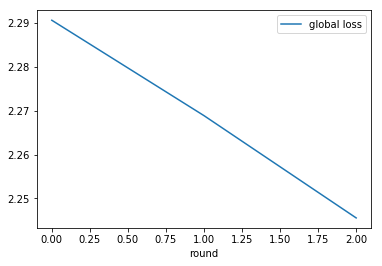

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# loss of global model on test set gets recorded twice per round
# [1::2] skips the record that takes place before that round's training has happened
ax.plot(manager.manager_loss_history[1::2], label="global loss")
ax.set_xlabel("round");
ax.legend();

print(len(manager.worker_loss_histories))

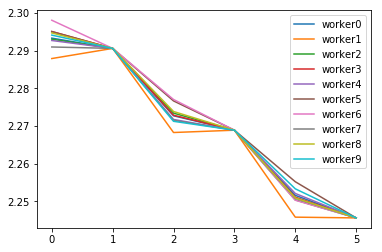

In [15]:
fig, ax = plt.subplots()

for i in range(len(manager.worker_loss_histories)):
    lbl = "worker" + str(i)
    ax.plot(manager.worker_loss_histories[i], label=lbl)
    ax.legend();